In [1]:
import functools
import numpy as np
import scipy.optimize as opt
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

rng = np.random.default_rng(93414286851068899262715314978330172806)

fig_format = "pdf"
savefig_opts = {
    "format": fig_format,
    "bbox_inches": "tight",
    "pad_inches": 0.0
}

In [2]:
def gaussian_kernel(X, Y, gamma):
    sq_norm = cdist(X, Y, 'sqeuclidean')
    return np.exp(-gamma * sq_norm)

In [3]:
def special_kernel(X, Y, eta):
    a = eta[0]
    b = eta[1]
    X_ = np.sin(2*np.pi*X.reshape(-1)+b)
    Y_ = np.sin(2*np.pi*Y.reshape(-1)+b)
    K = (1 + X @ Y.T)**2 + a * np.multiply.outer(X_, Y_)
    return K

In [4]:
def m(x):
    return np.zeros(np.array(x).shape)

# Prediction

In [5]:
# Constants & hyperparameters
start_year = 1958
train_months = 10 * 12
predict_months = 6 * 12

In [6]:
def load_data(path):
    # 10 years of data for learning
    data = np.genfromtxt(path, delimiter=',')
    X = data[:train_months,2]-start_year
    y_raw = data[:train_months,3]
    y_mean = np.mean(y_raw)
    y_std = np.sqrt(np.var(y_raw))
    y = (y_raw-y_mean)/y_std
    # the next 5 years for prediction
    X_pred = data[train_months:train_months+predict_months,2]-start_year
    y_pred = data[train_months:train_months+predict_months,3]

    return X, y_raw, y, X_pred, y_pred

Negative log-likelihood of the evidence
$$
    \log{p(y | S, \eta, \sigma_y^2)} =
    -\frac{1}{2} \left(
        \underbrace{y^{T} (\sigma_y^2 I_{N} + K_\eta(S))^{-1} y}_{t_1} +
        \underbrace{\log{\det{(\sigma_y^2 I_{N} + K_\eta(S))}}}_{t_2} +
        \underbrace{N \log{\sqrt{2 \pi}}}_{t_3}
    \right).
$$

In [7]:
def negLogLikelihood(params, kernel, S, y):
    noise_y = params[0]
    eta = params[1:]
    N = len(y)
    K_S = kernel(S, S, eta)
    t1 = y.T @ np.linalg.inv(noise_y * np.eye(N) + K_S) @ y
    t2 = np.log(np.linalg.det(noise_y * np.eye(N) + K_S))
    t3 = N * np.log(np.sqrt(2 * np.pi))
    log_likelihood = -0.5 * (t1 + t2 + t3)
    return -log_likelihood

Grid-search optimization of kernel using negative log-likelihood.

In [8]:
def optimize_params(ranges, kernel, Ngrid, S, y):
    opt_params = opt.brute(
        lambda params: negLogLikelihood(params, kernel, S, y),
        ranges,
        Ns=Ngrid,
        finish=None
    )
    noise_var = opt_params[0]
    eta = opt_params[1:]
    return noise_var, eta

Computing $f^\ast | y$ for predicting new value $y^\ast$ from $x^\ast$.

In [9]:
def conditional(S, y, x, noise_var, eta, kernel):
    N = len(S)
    K_S =  kernel(S, S, eta)
    K_Sx = kernel(S, x, eta)
    K_xx = kernel(x, x, eta)
    G = np.linalg.inv(noise_var * np.eye(N) + K_S)
    a = G @ y
    mustar = K_Sx.T @ a
    Sigmastar = K_xx - K_Sx.T @ G @ K_Sx
    return mustar, Sigmastar # return mean and covariance matrix

In [10]:
def predict(S, y, x, noise_var, eta, kernel):
    # Use kernel to predict obervations on `x_pred`
    prediction_mean_gp, Sigma_gp = conditional(S, y, x_pred, noise_var, eta, kernel)
    # We only need the diagonal term of the covariance matrix for the plots.
    var_gp = np.diag(Sigma_gp)

    return prediction_mean_gp, var_gp

In [11]:
def evaluate_prediction(prediction_mean_gp, var_gp, y_raw, y_pred):
    y_mean = np.mean(y_raw)
    y_std  = np.sqrt(np.var(y_raw))
    yout_m = prediction_mean_gp*y_std + y_mean
    yout_v = var_gp*y_std**2

    # Calculate # of points outside 95% confidence interval
    lower_bound = yout_m-1.96*yout_v**0.5
    upper_bound = yout_m+1.96*yout_v**0.5
    outside = np.logical_or(y_pred < lower_bound, y_pred > upper_bound)
    
    return r2_score(y_pred, yout_m), np.average(outside)

In [12]:
def plot_prediction(
    ax,
    S, y_raw, x_pred, y_pred,
    prediction_mean_gp, var_gp
):
    ax.plot(S + start_year, y_raw, color='blue', label='training data')
    ax.plot(x_pred + start_year, y_pred, color='red', label='test data')
    y_mean = np.mean(y_raw)
    y_std  = np.sqrt(np.var(y_raw))
    yout_m = prediction_mean_gp*y_std + y_mean
    yout_v = var_gp*y_std**2
    ax.plot(x_pred + start_year, yout_m, color='black', label='GP prediction')
    ax.fill_between(
        x_pred + start_year,
        yout_m-1.96*yout_v**0.5,
        yout_m+1.96*yout_v**0.5,
        alpha=.5,
        color='grey',
        label='GP uncertainty'
    )
    
    ax.set_xlabel('year')
    ax.set_ylabel('co2(ppm)')
    ax.legend()

In [13]:
# Load data & expand it to have the right shape
S, y_raw, y, S_pred, y_pred = load_data('co2_mm_mlo.csv')
X = np.expand_dims(S, 1)
x_pred = np.expand_dims(S_pred, 1)

## Part B (Gaussian kernel)

In [14]:
# Setup gaussian kernel and search space of parameters
kernel = gaussian_kernel
# If `noise_var` is too low then `det|noise_var * I + K(S)|`
# is 0 and so the log-lokelihood will be -inf, so we keep `noise_var` > 0.005
#         noise_var   eta[0] (γ)
ranges = ((5.e-3,1), (1.0,20.0))
Ngrid = 10

# Optimize parameters of kernel
noise_var, eta = optimize_params(ranges, kernel, Ngrid, X, y)
print("optimal params for Gaussian kernel:", noise_var, eta)

optimal params for Gaussian kernel: 0.005 [11.55555556]


In [15]:
prediction_mean_gp, var_gp = predict(X, y, x_pred, noise_var, eta, kernel)
r2, fraction_outside = evaluate_prediction(prediction_mean_gp, var_gp, y_raw, y_pred)
print(f"R^2 score: {r2}")
print(f"% test points outside 95% confidence interval: {fraction_outside:%}")

R^2 score: -7.511795780478044
% test points outside 95% confidence interval: 73.611111%


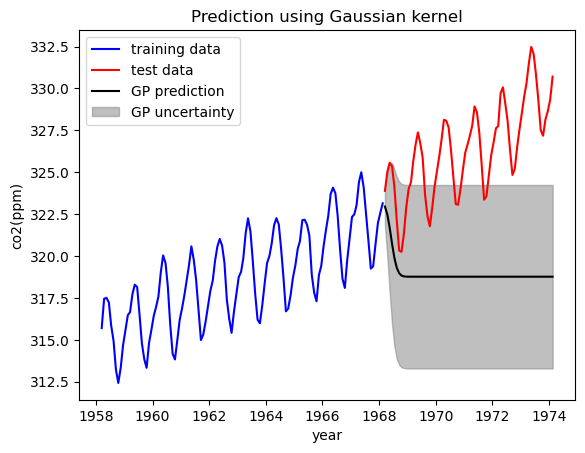

In [16]:
fig, ax = plt.subplots()
plot_prediction(
    ax,
    S, y_raw, S_pred, y_pred,
    prediction_mean_gp, var_gp
)
ax.set_title("Prediction using Gaussian kernel")
fig.savefig(f"gp_predict_gaussian.{fig_format}", **savefig_opts)

## Part C (Special kernel)

In [17]:
# Setup special kernel and search space of parameters
kernel = special_kernel
# If `noise_var` is too low then `det|noise_var * I + K(S)|`
# is 0 and so the log-lokelihood will be -inf, so we keep `noise_var` > 0.005
#         noise_var   eta[0] (a)    eta[1] (b)
ranges = ((5.e-3,1), (1.e-3,10.0), (1.e-3,10.0))
Ngrid = 10

# Optimize parameters of kernel
noise_var, eta = optimize_params(ranges, kernel, Ngrid, X, y)
print("optimal params for special kernel:", noise_var, eta)

optimal params for special kernel: 0.11555555555555556 [1.112 8.889]


In [18]:
prediction_mean_gp, var_gp = predict(X, y, x_pred, noise_var, eta, kernel)
r2, fraction_outside = evaluate_prediction(prediction_mean_gp, var_gp, y_raw, y_pred)
print(f"R^2 score: {r2}")
print(f"% test points outside 95% confidence interval: {fraction_outside:%}")

R^2 score: 0.6105973511225149
% test points outside 95% confidence interval: 48.611111%


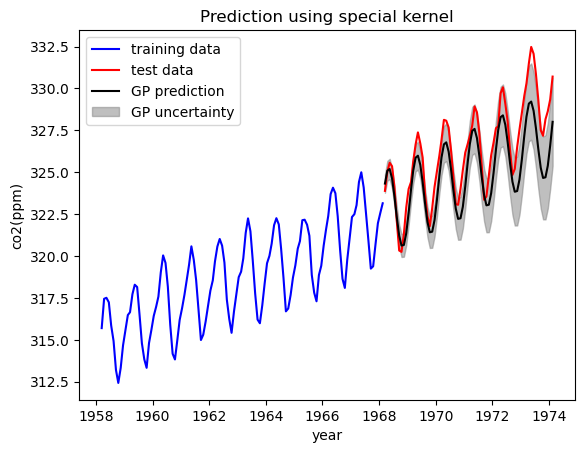

In [19]:
fig, ax = plt.subplots()
plot_prediction(
    ax,
    S, y_raw, S_pred, y_pred,
    prediction_mean_gp, var_gp
)
ax.set_title("Prediction using special kernel")
fig.savefig(f"gp_predict_special.{fig_format}", **savefig_opts)